<a href="https://colab.research.google.com/github/joliveiraas/polyps-seg/blob/main/unet_effnet_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polyps Segmentation: U-Net with Pretrained EfficientNetB0 as Encoder



# 1. Data

### 1.1. Upload and organize data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
import requests
import zipfile
from pathlib import Path
import shutil
import os

# Upload data from GitHub
root = Path('root/')
data = root / 'data'

if not data.is_dir():
  data.mkdir(parents=True, exist_ok=True)

with open(root / 'data.zip', "wb") as f:
  request = requests.get('https://github.com/joliveiraas/kvasir-seg/raw/main/large%20data/kvasir-seg-large.zip')
  f.write(request.content)

  with zipfile.ZipFile(root / 'data.zip', 'r') as zip_ref:
    zip_ref.extractall(data)

# Source paths
images = data / 'images'
masks =  data / 'masks'

imgs_list = os.listdir(images)
masks_list = os.listdir(masks)

# Train and test split
train_imgs_paths, test_imgs_paths, train_masks_paths, test_masks_paths = train_test_split(
    imgs_list,
    masks_list,
    test_size=0.10,
    random_state=42
)

# Train and validation split
train_imgs_paths, val_imgs_paths, train_masks_paths, val_masks_paths = train_test_split(
    train_imgs_paths,
    train_masks_paths,
    test_size=0.111,
    random_state=42
)

### 1.2. Custom dataset class

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 512
BATCH_SIZE = 20
PIN_MEMORY = True if device == 'cuda' else False

In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
import os
import numpy as np

class CustomDataset(Dataset):
  def __init__(self, imgs_dir, masks_dir, imgs_paths, masks_paths, transform=None):
    self.imgs_dir = imgs_dir
    self.masks_dir = masks_dir
    self.imgs_paths = imgs_paths
    self.masks_paths = masks_paths
    self.transform = transform

  def __len__(self):
    return len(self.imgs_paths)

  def __getitem__(self, idx):
    img_path = os.path.join(self.imgs_dir, self.imgs_paths[idx])
    mask_path = os.path.join(self.masks_dir, self.masks_paths[idx])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, 0)

    if transform is not None:
      image = self.transform(image)
      mask = self.transform(mask)

    return image, mask

### 1.3. Transform

In [ ]:
from torchvision import transforms as tf

transform = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((IMG_SIZE, IMG_SIZE)),
    tf.ToTensor()
])

In [ ]:
train_dataset = CustomDataset(images, masks, train_imgs_paths, train_masks_paths, transform)
val_dataset = CustomDataset(images, masks, val_imgs_paths, val_masks_paths, transform)
test_dataset = CustomDataset(images, masks, test_imgs_paths, test_masks_paths, transform)

In [ ]:
print(f'Train dataset: {len(train_dataset)}')
print(f'Validation dataset: {len(val_dataset)}')
print(f'Test dataset: {len(test_dataset)}')

Train dataset: 800
Validation dataset: 100
Test dataset: 100


### 1.4. Visualizing dataset


Original size: torch.Size([3, 512, 512]) -> [C, H, W]
Image permute: torch.Size([512, 512, 3]) -> [H, W, C]
Length of train_dataset: 800


(-0.5, 511.5, 511.5, -0.5)

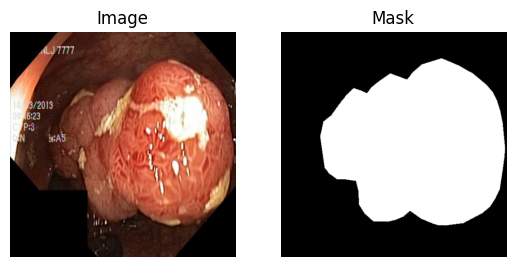

In [ ]:
import matplotlib.pyplot as plt
from random import randint
idx = randint(0, len(train_dataset)-1)
img, mask = train_dataset[idx][0], train_dataset[idx][1]

img_permute = img.permute(1, 2, 0)
mask_permute = mask.permute(1, 2, 0)

print(f'Original size: {img.shape} -> [C, H, W]')
print(f'Image permute: {img_permute.shape} -> [H, W, C]')
print(f'Length of train_dataset: {len(train_dataset)}')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_permute)
ax[0].set_title("Image")
ax[0].axis(False)
ax[1].imshow(mask_permute, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis(False)

### 1.5. Dataloaders

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              pin_memory=PIN_MEMORY,
                              num_workers=os.cpu_count())

val_dataloader = DataLoader(dataset=val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             pin_memory=PIN_MEMORY,
                             num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             pin_memory=PIN_MEMORY,
                             num_workers=os.cpu_count())

train_dataloader, val_dataset, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7afb7ecb2890>,
 <torch.utils.data.dataloader.DataLoader at 0x7afb7ecb0640>)

# 2. Model

* Encoder: EfficientNet_B0
* ImageNet pre-trained weights

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 39.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=281e5373d816ad5322a4793156dc017a4a589031e5809d781c77a33c70cf5f8f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c9b467e8e06a2fdbd7f75e27db16c92aef840358451df9d3f610635d0ace0f11
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 74.4MB/s]


In [ ]:
# Testing model on a fake image
fake_img = torch.randn(1, 3, 128, 128).to(device)
result = model(fake_img)
result.shape

torch.Size([1, 1, 128, 128])

# 3. Training

## 3.1. Utils functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

  model.train()
  train_loss = 0

  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  train_loss /= len(train_dataset)
  return train_loss

In [ ]:
from sklearn.metrics import balanced_accuracy_score

def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):

  model.eval()
  val_loss = 0
  _y_pred = np.array([])
  _y_true = np.array([])

  with torch.inference_mode():
    for (X, y) in val_dataloader:
      X = X.to(device)
      y = y.to(device)
      val_pred = model(X)
      val_loss += loss_fn(val_pred, y).item()

      mask = y.squeeze().cpu().numpy()
      map = np.zeros(mask.shape, np.float32)
      map[mask != 0] = 1

      threshold = 0.5
      seg = (val_pred > threshold).int().squeeze().cpu().numpy()

      y_true = map.flatten()
      y_pred = seg.flatten()

      _y_true = np.concatenate((_y_true, y_true), axis=None)
      _y_pred = np.concatenate((_y_pred, y_pred), axis=None)

    val_loss /= len(val_dataset)

  val_acc = balanced_accuracy_score(_y_true, _y_pred)

  return val_loss, val_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):

  # Create empty results dictionary
  results = {"epochs": [],
             "train_loss": [],
             "val_loss": [],
             "val_acc": []}


  for epoch in tqdm(range(epochs)):
    ### Training
    train_loss = train_step(model=model,
                            dataloader=train_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)

    ### Validating
    val_loss, val_acc = val_step(model=model,
                                 dataloader=val_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)

    scheduler.step(val_loss)

    # Print out what´s happening
    print(
      f"epoch: {epoch+1} | "
      f"train_loss: {train_loss:.6f} | "
      f"val_loss: {val_loss:.6f} | "
      f"val_acc: {val_acc:.6f} | "
    )

    # Update results dictionary
    results["epochs"].append(epoch+1)
    results["train_loss"].append(train_loss)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)


  return results

In [ ]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

## 3.2. Training

In [ ]:
from timeit import default_timer as timer
start_time = timer()

LR = 0.0001
EPOCHS = 60
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.5,
                                                       patience=5,
                                                       verbose=True)

# Train results
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      scheduler=scheduler,
                      epochs=EPOCHS,
                      device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/60 [00:00<?, ?it/s]

epoch: 1 | train_loss: 0.040272 | val_loss: 0.037186 | val_acc: 0.817917 | 
epoch: 2 | train_loss: 0.036435 | val_loss: 0.035628 | val_acc: 0.772427 | 
epoch: 3 | train_loss: 0.034908 | val_loss: 0.035010 | val_acc: 0.777647 | 
epoch: 4 | train_loss: 0.034235 | val_loss: 0.034722 | val_acc: 0.750566 | 
epoch: 5 | train_loss: 0.033827 | val_loss: 0.034417 | val_acc: 0.777016 | 
epoch: 6 | train_loss: 0.033528 | val_loss: 0.034046 | val_acc: 0.821413 | 
epoch: 7 | train_loss: 0.033310 | val_loss: 0.033875 | val_acc: 0.807779 | 
epoch: 8 | train_loss: 0.033179 | val_loss: 0.033657 | val_acc: 0.842251 | 
epoch: 9 | train_loss: 0.032985 | val_loss: 0.033559 | val_acc: 0.830384 | 
epoch: 10 | train_loss: 0.032915 | val_loss: 0.033342 | val_acc: 0.856645 | 
epoch: 11 | train_loss: 0.032788 | val_loss: 0.033263 | val_acc: 0.870859 | 
epoch: 12 | train_loss: 0.032700 | val_loss: 0.033162 | val_acc: 0.863309 | 
epoch: 13 | train_loss: 0.032611 | val_loss: 0.033110 | val_acc: 0.886464 | 
epoch: 1

In [ ]:
# Save the model
save_model(model=model,
           target_dir="/content/drive/MyDrive/kvasir-seg",
           model_name=f"kvasir-seg-effnet_b0-final.pth")

[INFO] Saving model to: /content/drive/MyDrive/kvasir-seg/kvasir-seg-effnet_b0-final.pth


### 3.3. Visualizing training curves

In [ ]:
# Loss over training
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(model_results["epochs"], model_results["train_loss"], label="train", color="purple")
plt.plot(model_results["epochs"], model_results["val_loss"], label="val", color="orange")
plt.title("Training and Validation Loss")
plt.xlabel(f"Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# Evaluation metrics over training
plt.subplot(1, 2, 2)
plt.plot(model_results["epochs"], model_results["val_acc"], label="val", color="green")
#plt.plot(model_results["iou"], label="IoU", color="orange")
plt.title("Validation Accuracy")
plt.xlabel(f"Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

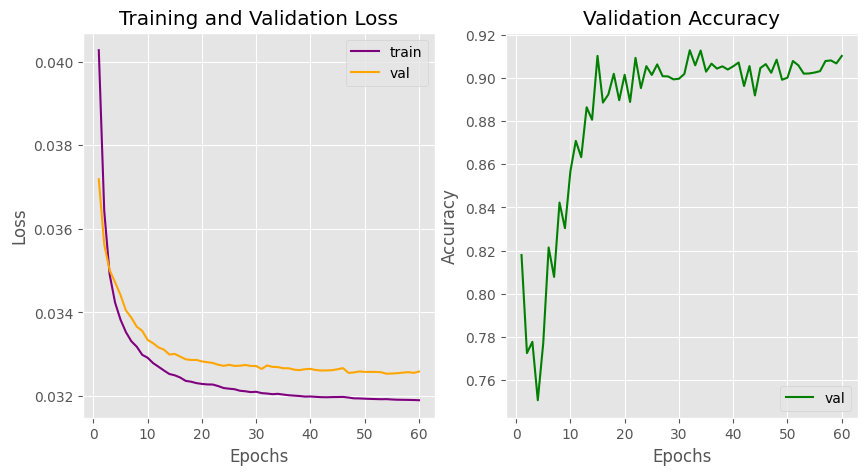

In [ ]:
# Save training metrics
import pandas as pd

df = pd.DataFrame(model_results)
df.to_csv(f'/content/drive/MyDrive/kvasir-seg/training-process-final.csv', index=False)

# 4. Testing

### 4.1. Getting test metrics

In [ ]:
test_metrics = {'balanced_accuracy': [],
                'precision': [],
                'recall': [],
                'jaccard': [],
                'f1_score': [],
                'matthews_coef': []}

In [ ]:
model.eval()
_y_pred = np.array([])
_y_true = np.array([])

with torch.inference_mode():
  for (X, y) in test_dataloader:
    X = X.to(device)
    y = y.to(device)
    test_pred = model(X)

    mask = y.squeeze().cpu().numpy()
    map = np.zeros(mask.shape, np.float32)
    map[mask != 0] = 1

    threshold = 0.5
    seg = (test_pred > threshold).int().squeeze().cpu().numpy()

    y_true = map.flatten()
    y_pred = seg.flatten()

    _y_true = np.concatenate((_y_true, y_true), axis=None)
    _y_pred = np.concatenate((_y_pred, y_pred), axis=None)

In [ ]:
from sklearn.metrics import jaccard_score, balanced_accuracy_score, precision_score, f1_score, recall_score, matthews_corrcoef

# Accuracy
balanced_accuracy = balanced_accuracy_score(_y_true, _y_pred)

# Precision
precision = precision_score(_y_true, _y_pred, average='binary')

# Recall:
recall = recall_score(_y_true, _y_pred, average='binary')

# IoU
jaccard = jaccard_score(_y_true, _y_pred)

# F1 (DSC)
f1_score = f1_score(_y_true, _y_pred, average='binary')

# Matthews Correlation Coefficient
matthews_coef = matthews_corrcoef(_y_true, _y_pred)

In [ ]:
test_metrics['balanced_accuracy'].append(balanced_accuracy)
test_metrics['precision'].append(precision)
test_metrics['recall'].append(recall)
test_metrics['jaccard'].append(jaccard)
test_metrics['f1_score'].append(f1_score)
test_metrics['matthews_coef'].append(matthews_coef)

In [ ]:
test_metrics

{'balanced_accuracy': [0.9188474883713573],
 'precision': [0.9588474155766759],
 'recall': [0.8449952101610151],
 'jaccard': [0.8154229321326134],
 'f1_score': [0.8983283373805573],
 'matthews_coef': [0.8818697171179672]}

In [ ]:
df = pd.DataFrame(test_metrics)
df.to_csv(f'/content/drive/MyDrive/kvasir-seg/test-metrics-results-final.csv', index=False)

### 4.2. Visualizing predictions

In [ ]:
THRESHOLD = 0.5

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def prepare_plot(img, true_mask, pred_mask):
  fig, ax = plt.subplots(1, 3, figsize=(5, 5))

  ax[0].imshow(img)
  ax[0].axis(False)
  ax[0].set_title("Image")
  ax[1].imshow(img)
  ax[1].imshow(true_mask)
  ax[1].axis(False)
  ax[1].set_title("Original mask")
  ax[2].imshow(img)
  ax[2].imshow(pred_mask)
  ax[2].axis(False)
  ax[2].set_title("Predicted mask")

  fig.tight_layout()
  fig.show()

In [ ]:
def show_mask(mask):

  color = np.array([255, 0, 0, 0.6]) # R, G, B, A
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  mask_image = mask_image.astype(np.uint8)

  return mask_image

In [ ]:
def make_predictions(model, img_path):
  model.eval()

  with torch.inference_mode():
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    orig = image.copy()

    filename = img_path.split(os.path.sep)[-1]
    true_mask_path = os.path.join(masks, filename)

    true_mask = cv2.imread(true_mask_path, 0)
    true_mask = cv2.resize(true_mask, (IMG_SIZE, IMG_SIZE))

    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image).to(device)

    pred_mask = model(image).squeeze()
    pred_mask = pred_mask.cpu().numpy()

    pred_mask = (pred_mask > THRESHOLD) * 255
    pred_mask = pred_mask.astype(np.uint8)

    true_mask_color = show_mask(true_mask)
    pred_mask_color = show_mask(pred_mask)

    prepare_plot(orig, true_mask_color, pred_mask_color)

Loading up test image paths...


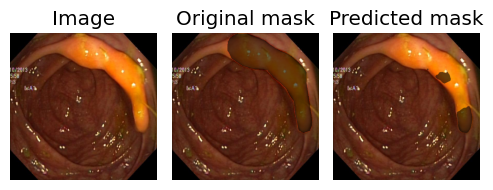

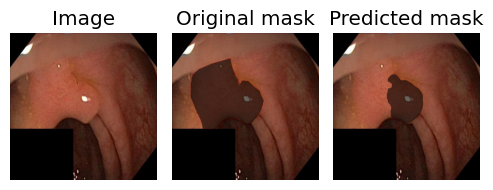

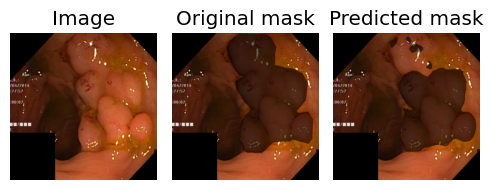

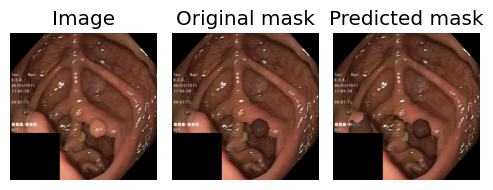

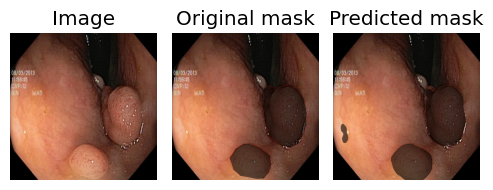

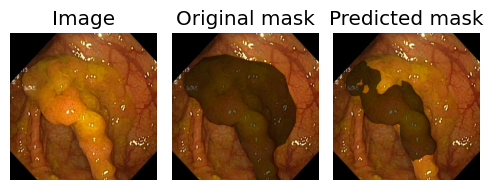

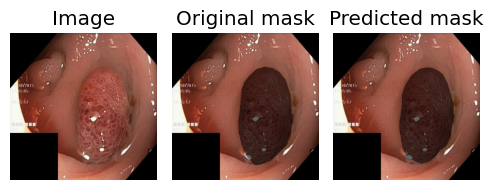

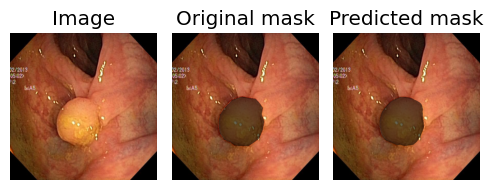

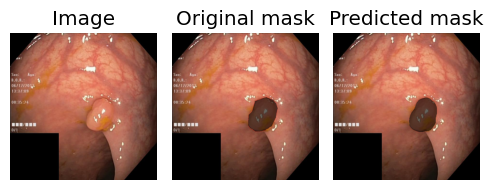

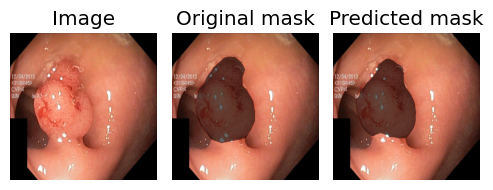

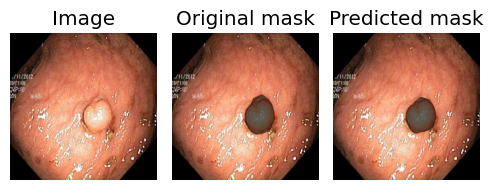

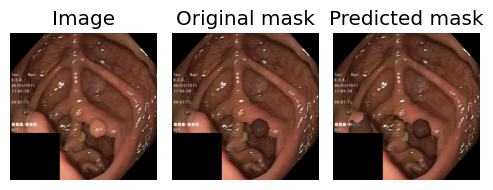

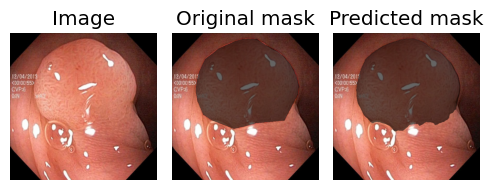

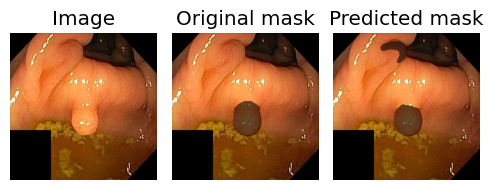

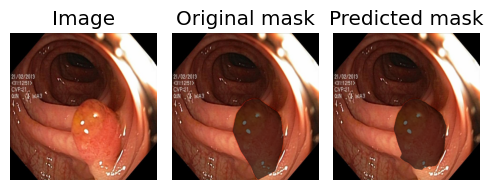

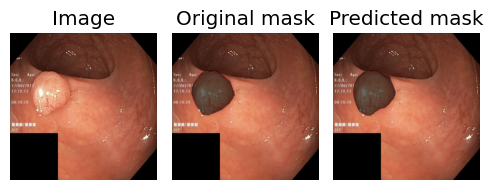

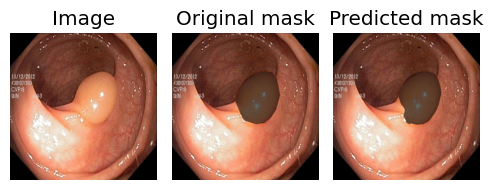

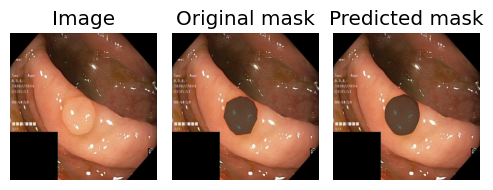

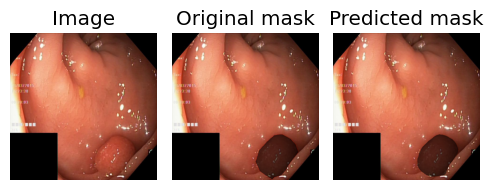

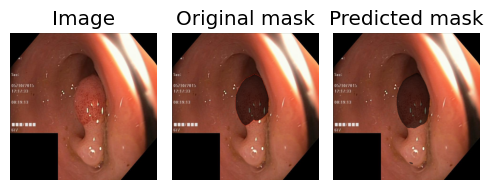

In [ ]:
print('Loading up test image paths...')
imgs_paths = [os.path.join(images, filename) for filename in test_imgs_paths]
imgs_list = np.random.choice(imgs_paths, size=20)

for path in imgs_list:
  make_predictions(model, path)